<a href="https://colab.research.google.com/github/Nishthamaybeme/automatic-casting-defect-detection-webapp/blob/main/vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [30]:
#new code
# Step 1: Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Step 2: Set the path to your data
base_path = '/content/drive/MyDrive/crime game/casting_data/casting_data'
train_dir = '/content/drive/MyDrive/crime game/casting_data/casting_data/train'
test_dir = '/content/drive/MyDrive/crime game/casting_data/casting_data/test (1)'

# Step 3: Define image size and batch size
IMG_SIZE = (224, 224)  # Image size for ViT
BATCH_SIZE = 32

# Step 4: Data Augmentation and Loading
train_datagen = ImageDataGenerator(
    rescale=1.0/255,    # Normalize pixel values between 0 and 1
    rotation_range=20,  # Random rotations for data augmentation
    width_shift_range=0.2,  # Shift the image horizontally
    height_shift_range=0.2,  # Shift the image vertically
    shear_range=0.2,   # Shear the image
    zoom_range=0.2,    # Random zoom
    horizontal_flip=True,  # Flip the image horizontally
    fill_mode='nearest'  # Fill missing pixels after transformations
)

test_datagen = ImageDataGenerator(rescale=1.0/255)  # Only rescaling for test set

# Step 5: Create Data Generators for training and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Path to the training directory
    target_size=IMG_SIZE,  # Resize all images to the target size (224x224)
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary classification, use 'categorical' for more than 2 classes
    shuffle=True  # Shuffle data for better generalization
)

test_generator = test_datagen.flow_from_directory(
    test_dir,  # Path to the testing directory
    target_size=IMG_SIZE,  # Resize all images to the target size (224x224)
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary classification
    shuffle=False  # Do not shuffle for evaluation
)

# Step 6: Display class indices for reference
print("Class Indices:", train_generator.class_indices)


Found 4077 images belonging to 2 classes.
Found 715 images belonging to 2 classes.
Class Indices: {'def_front': 0, 'ok_front (1)': 1}


In [31]:
import os
import shutil
import random

# Function to perform oversampling and undersampling
def balance_dataset(train_def_path, train_ok_path, target_dir):
    # Define the target path for balanced dataset
    balanced_train_def_path = os.path.join(target_dir, 'def_front')
    balanced_train_ok_path = os.path.join(target_dir, 'ok_front')

    # Create directories for the balanced dataset
    os.makedirs(balanced_train_def_path, exist_ok=True)
    os.makedirs(balanced_train_ok_path, exist_ok=True)

    # List all the files in the directories
    def_front_images = os.listdir(train_def_path)
    ok_front_images = os.listdir(train_ok_path)

    # Number of samples in each class
    num_def_front = len(def_front_images)
    num_ok_front = len(ok_front_images)

    # Oversample the minority class (ok_front)
    if num_ok_front < num_def_front:
        # Calculate how many more images we need for ok_front
        oversample_count = num_def_front - num_ok_front

        # Randomly duplicate ok_front images to match the number of def_front images
        oversampled_ok_front_images = random.choices(ok_front_images, k=oversample_count)

        # Copy oversampled images to the balanced dataset directory
        for img in oversampled_ok_front_images:
            shutil.copy(os.path.join(train_ok_path, img), balanced_train_ok_path)

    # Undersample the majority class (def_front)
    if num_ok_front < num_def_front:
        # Randomly select a subset of def_front images to match the number of ok_front images
        undersample_count = num_ok_front

        # Randomly select images from def_front
        undersampled_def_front_images = random.sample(def_front_images, undersample_count)

        # Copy the selected images to the balanced dataset directory
        for img in undersampled_def_front_images:
            shutil.copy(os.path.join(train_def_path, img), balanced_train_def_path)

    print(f"Balanced training data: def_front = {len(os.listdir(balanced_train_def_path))}, ok_front = {len(os.listdir(balanced_train_ok_path))}")

# Balance the dataset by oversampling and undersampling
balanced_train_dir = '/content/drive/MyDrive/crime game/casting_data/casting_data/train_balanced'
balance_dataset(train_def_path, train_ok_path, balanced_train_dir)


Balanced training data: def_front = 709, ok_front = 689


Using device: cuda
Class Indices: {'def_front': 0, 'ok_front': 1}
Epoch 1/10, Loss: 0.5401
Epoch 2/10, Loss: 0.1074
Epoch 3/10, Loss: 0.0484
Epoch 4/10, Loss: 0.0903
Epoch 5/10, Loss: 0.0440
Epoch 6/10, Loss: 0.0198
Epoch 7/10, Loss: 0.0269
Epoch 8/10, Loss: 0.0165
Epoch 9/10, Loss: 0.0172
Epoch 10/10, Loss: 0.0120
              precision    recall  f1-score   support

   def_front       0.86      0.98      0.92       453
    ok_front       0.96      0.72      0.83       262

    accuracy                           0.89       715
   macro avg       0.91      0.85      0.87       715
weighted avg       0.90      0.89      0.88       715



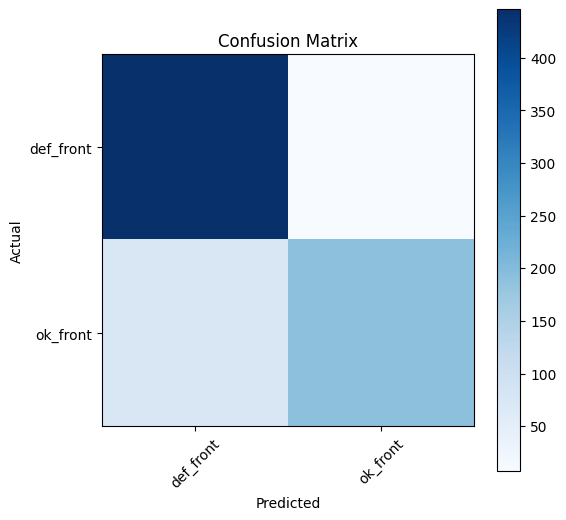

RuntimeError: Parent directory /path/to/save does not exist.

In [32]:
import os
import timm  # Vision Transformer (ViT) models
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for ViT
    transforms.ToTensor(),         # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Update dataset paths for the balanced dataset
train_dataset = datasets.ImageFolder(root=balanced_train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create data loaders for balanced dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Print class indices
print(f"Class Indices: {train_dataset.class_to_idx}")

# Load a pre-trained Vision Transformer (ViT) model
model = timm.create_model('vit_base_patch16_224', pretrained=True)
num_features = model.head.in_features
model.head = nn.Linear(num_features, 2)  # Two output classes (def_front, ok_front)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training the model
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(2), train_dataset.classes, rotation=45)
plt.yticks(range(2), train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [33]:
import os

# Define the model save path
model_save_path = "/content/drive/MyDrive/crime_game_model.pth"

# Ensure the parent directory exists
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/crime_game_model.pth


<ipython-input-6-4bf4b35e9582>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


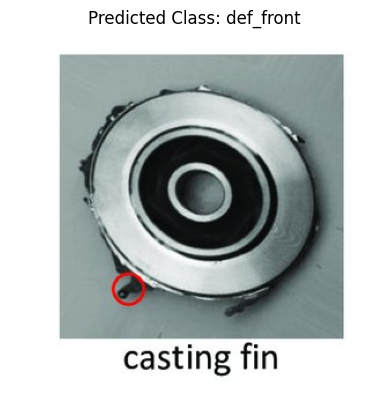

In [6]:
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import timm  # Vision Transformer (ViT) models
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
# Path to the saved model and the custom image
model_save_path = "/content/drive/MyDrive/crime_game_model.pth"  # Update this path
custom_image_path = "/content/drive/MyDrive/The-examples-of-the-open-hole-defect-and-the-casting-fin-defect-The-red-circles-are_Q320.jpg"  # Update with your image path

# Load the trained model
model = timm.create_model('vit_base_patch16_224', pretrained=False)
num_features = model.head.in_features
model.head = nn.Linear(num_features, 2)  # Two output classes (def_front, ok_front)
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image = Image.open(custom_image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Predict the class
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted_class = torch.max(outputs, 1)

# Map class index to label
class_labels = ["def_front", "ok_front"]
predicted_label = class_labels[predicted_class.item()]

# Display the image and prediction
plt.imshow(image)
plt.title(f"Predicted Class: {predicted_label}")
plt.axis("off")
plt.show()


In [7]:
# Replace with the correct path to your model in Drive
!cp /content/drive/MyDrive/crime_game_model.pth


cp: missing destination file operand after '/content/drive/MyDrive/crime_game_model.pth'
Try 'cp --help' for more information.


In [8]:
!git clone https://github.com/Nishthamaybeme/automatic-casting-defect-detection-webapp.git


Cloning into 'automatic-casting-defect-detection-webapp'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), done.
Resolving deltas: 100% (1/1), done.


In [11]:
!cp https://colab.research.google.com/drive/1iuicv4SRbq2h63F4ZmSSgPnx1g2Fyssg?usp=sharing\/vision_transformer.ipynb /content/automatic-casting-defect-detection-webapp/


cp: cannot stat 'https://colab.research.google.com/drive/1iuicv4SRbq2h63F4ZmSSgPnx1g2Fyssg?usp=sharing/vision_transformer.ipynb': No such file or directory
